# Initialization


In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


Reading part (1/n) of the data

In [0]:
def skiprow(i, n):
    if i % n == 0:
       return False
    return True


Change n to load more, or less of the data.

In [3]:
n=5
train_url='https://github.com/shobhitshah/MNIST-digit-recognizer/blob/develop/data/mnist-in-csv/mnist_train.csv.zip?raw=true'
test_url='https://github.com/shobhitshah/MNIST-digit-recognizer/blob/develop/data/mnist-in-csv/mnist_test.csv.zip?raw=true'
train = pd.read_csv(train_url, compression='zip', skiprows = lambda x: skiprow(x, n))
test = pd.read_csv(test_url, compression='zip' , skiprows = lambda x: skiprow(x, 1))

train.shape

(12000, 785)

In [4]:
train.sample(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
3244,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3005,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1249,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10628,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Feature selection

In [0]:
y=train.label
X=train.drop('label', axis=1)
X_test = test.drop('label', axis=1)


# Define models

Multi label models.

In [0]:
models = []
models.append(('KNN', KNeighborsClassifier(5)))
models.append(('Linear SVM', SVC(gamma='scale', C=1, decision_function_shape='ovo')))
models.append(('Neural Net', MLPClassifier(alpha=0.0001, solver='sgd')))
#models.append(('XGB', XGBClassifier(objective='multi:softmax', num_class=10)))
models.append(('LR', LogisticRegression(solver="saga", multi_class="multinomial", max_iter=1000))) # ovr - one versus reset
models.append(('RF', RandomForestClassifier(max_depth=5, n_estimators=10)))


# Model fitting and prediction

In [0]:
def model_score(name, model, X, y, val_y, y_pred, y_test, icv):
    #print('Running CV score')
    cvscore = cross_val_score(model, X, y, cv=icv)
    print('Model {0} score: {1:.4f} and std dev: {2:.4f}'.format(name, cvscore.mean(), cvscore.std()))
    print('Validation variance score: %.4f' % r2_score(val_y, y_pred))
    print('Test variance score: %.4f' % r2_score(test.label, y_test))

    return cvscore, r2_score(val_y, y_pred), r2_score(test.label, y_test)

In [0]:
def cv_fit_and_predict(models, X, y):
    results = []
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
    for name, model in models:
        #print("Fitting model {}".format(name))
        m = model.fit(train_X, train_y)
        #print("Fitted model is {}".format(m))
        #print('Running prediction')
        y_pred = model.predict(val_X)
        y_test = model.predict(X_test)
        score, val_r2, test_r2 = model_score(name, model, X, y, val_y, y_pred, y_test, 10)
        results.append((name, score, val_r2, test_r2))
    print("Done")
    return results


In [9]:
results = cv_fit_and_predict(models, X, y)

Model KNN score: 0.9441 and std dev: 0.0083
Validation variance score: 0.8512
Test variance score: 0.8851
Model Linear SVM score: 0.9588 and std dev: 0.0059
Validation variance score: 0.8990
Test variance score: 0.9150


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Model Neural Net score: 0.7939 and std dev: 0.1318
Validation variance score: 0.7347
Test variance score: 0.7692


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Model LR score: 0.8699 and std dev: 0.0115
Validation variance score: 0.7393
Test variance score: 0.7747
Model RF score: 0.7955 and std dev: 0.0152
Validation variance score: 0.5865
Test variance score: 0.6302
Done


# Validation and results

In [0]:
def model_validation(results):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.boxplot(results[:,1])
    ax.set_xticklabels(results[:,0])
    ax.set_title('Model CV score')
    plt.show()
    
    plt.figure(figsize=(8, 5))
    plt.bar(results[:,0], results[:,2])
    plt.xlabel('Models')
    plt.ylabel('Var score')
    plt.title('Models variance score')
    plt.show()
    
    plt.figure(figsize=(8, 5))
    plt.bar(results[:,0], results[:,3])
    plt.xlabel('Models')
    plt.ylabel('Var score')
    plt.title('Test variance score')
    plt.show()
    
    return 0

In [0]:
np_results=np.array(results, object)

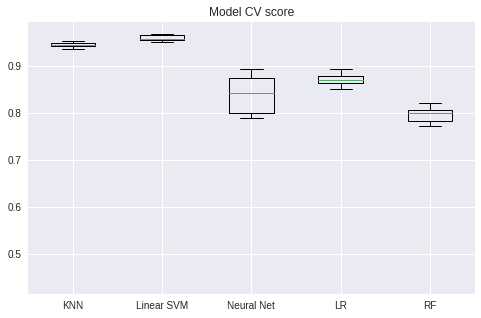

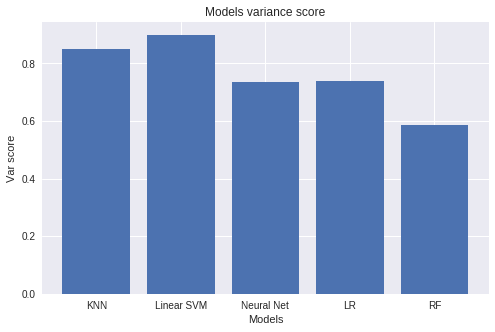

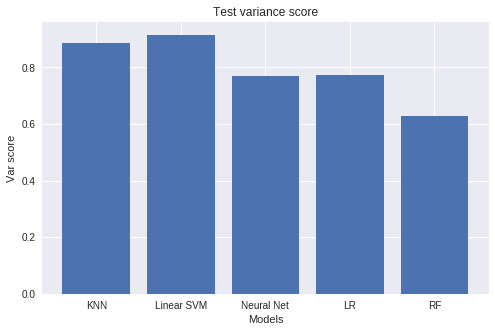

In [12]:
status = model_validation(np_results)

fi = imodel.fit(X, y).feature_importances_
pos = np.arange(len(X.columns))
print("Best performing model", imodel)
plt.figure(figsize=(13, 8))
plt.barh(pos, fi)
plt.title("Feature Importance")
plt.xlabel("Model Accuracy")
plt.ylabel("Features")
plt.yticks(pos, (list(X)))
plt.show()

preds = imodel.predict(X_test)
print('Variance score: %.4f' % r2_score(test.label, preds))

pd.DataFrame({"ImageId": list(range(1,len(preds)+1)), "Label": preds, "test_label":test.label})
